In [1]:
import os
import pandas as pd
import pandas_plink as pl
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.transforms.functional import to_pil_image
from GenoDrawingLib.models import Encoder,Decoder,Embedding_predictor
from GenoDrawingLib.dataset import snps_to_embd_dataset


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [2]:
sn = pl.read_plink1_bin(bed="Snp_data/SNPs_dataset.bed",
                        bim="Snp_data/SNPs_dataset.bim",
                        fam="Snp_data/SNPs_dataset.fam")
sn["variant"] = sn["snp"]
snp_list = pd.read_csv("Snp_data/Final_list_snps.csv", header=None)[0].tolist()
snps_df = pd.DataFrame(sn.loc[:, snp_list].values,
                       index=[e.lower() for e in sn.loc[:, snp_list].sample.values.tolist()])
snp_list_random = pd.read_csv("Snp_data/list_random.csv", header=None)[0].tolist()
snps_df_random = pd.DataFrame(sn.loc[:, snp_list_random].values,
                       index=[e.lower() for e in sn.loc[:, snp_list_random].sample.values.tolist()])

Mapping files: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


In [3]:
dims = 64
encoder = Encoder(dims = dims)
encoder.load_state_dict(torch.load("AE_model/64_encoders_35_epochs/model_data_7_2_2023_15h/encoder_7_2_2023_15h.h5"))
decoder = Decoder(dims = dims)
decoder.load_state_dict(torch.load("AE_model/64_encoders_35_epochs/model_data_7_2_2023_15h/decoder_7_2_2023_15h.h5"))
embedding_predictor_targeted = Embedding_predictor(dims=dims,n_snps=150)
embedding_predictor_targeted.load_state_dict(torch.load("Embedding_predictors/Embedding_targeted/model_data_9_2_2023_15h/embedding_predictor_9_2_2023_15h.h5"))
embedding_predictor_random = Embedding_predictor(dims=dims,n_snps=150)
embedding_predictor_random.load_state_dict(torch.load("Embedding_predictors/Embedding_random/model_data_150_snps_iter_1/150_snps.h5"))
encoder.eval()
decoder.eval()
embedding_predictor_targeted.eval()
embedding_predictor_random.eval()

Embedding_predictor(
  (snp_predictor): Sequential(
    (0): Linear(in_features=150, out_features=300, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=300, out_features=64, bias=True)
    (3): Sigmoid()
  )
)

In [4]:
folders = [os.path.join("Example_images",e) for e in os.listdir("Example_images")]
test_random = snps_to_embd_dataset(folders,snps_df_random,encoder,decoder,device)
test_targeted = snps_to_embd_dataset(folders,snps_df,encoder,decoder,device)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
example_images = [Image.open(os.path.join(e,os.listdir(e)[0])) for e in folders]
ground_truth_images = [to_pil_image(e[0]) for e in test_random]
images_targeted = []
images_random = []
embedding_predictor_targeted.to(device)
embedding_predictor_random.to(device)
decoder.to(device)
for e in range(3):
    snp_targeted = torch.reshape(torch.tensor(test_targeted[e][1]),shape=(1,150))
    snp_random = torch.reshape(torch.tensor(test_random[e][1]),shape=(1,150))
    if torch.cuda.is_available():
        prediction_targeted = embedding_predictor_targeted(snp_targeted.to(device)).detach().cpu()
        prediction_random = embedding_predictor_random(snp_random.to(device)).detach().cpu()
        decoded_image_targeted = decoder(prediction_targeted.to(device)).detach().cpu()
        decoded_image_random = decoder(prediction_random.to(device)).detach().cpu()
        images_targeted.append(to_pil_image(decoded_image_targeted[0]))
        images_random.append(to_pil_image(decoded_image_random[0]))
    else:
        prediction_targeted = embedding_predictor_targeted(snp_targeted).detach()
        prediction_random = embedding_predictor_random(snp_random).detach()
        decoded_image_targeted = decoder(torch.from_numpy(prediction_targeted)).detach()
        decoded_image_random = decoder(torch.from_numpy(prediction_random)).detach()
        images_targeted.append(to_pil_image(decoded_image_targeted[0]))
        images_random.append(to_pil_image(decoded_image_random[0]))

del embedding_predictor_random
del embedding_predictor_targeted
torch.cuda.empty_cache()

In [6]:
images_final = []
for i in range(3):
    images_final.append(example_images[i])
    images_final.append(ground_truth_images[i])
    images_final.append(images_targeted[i])
    images_final.append(images_random[i])

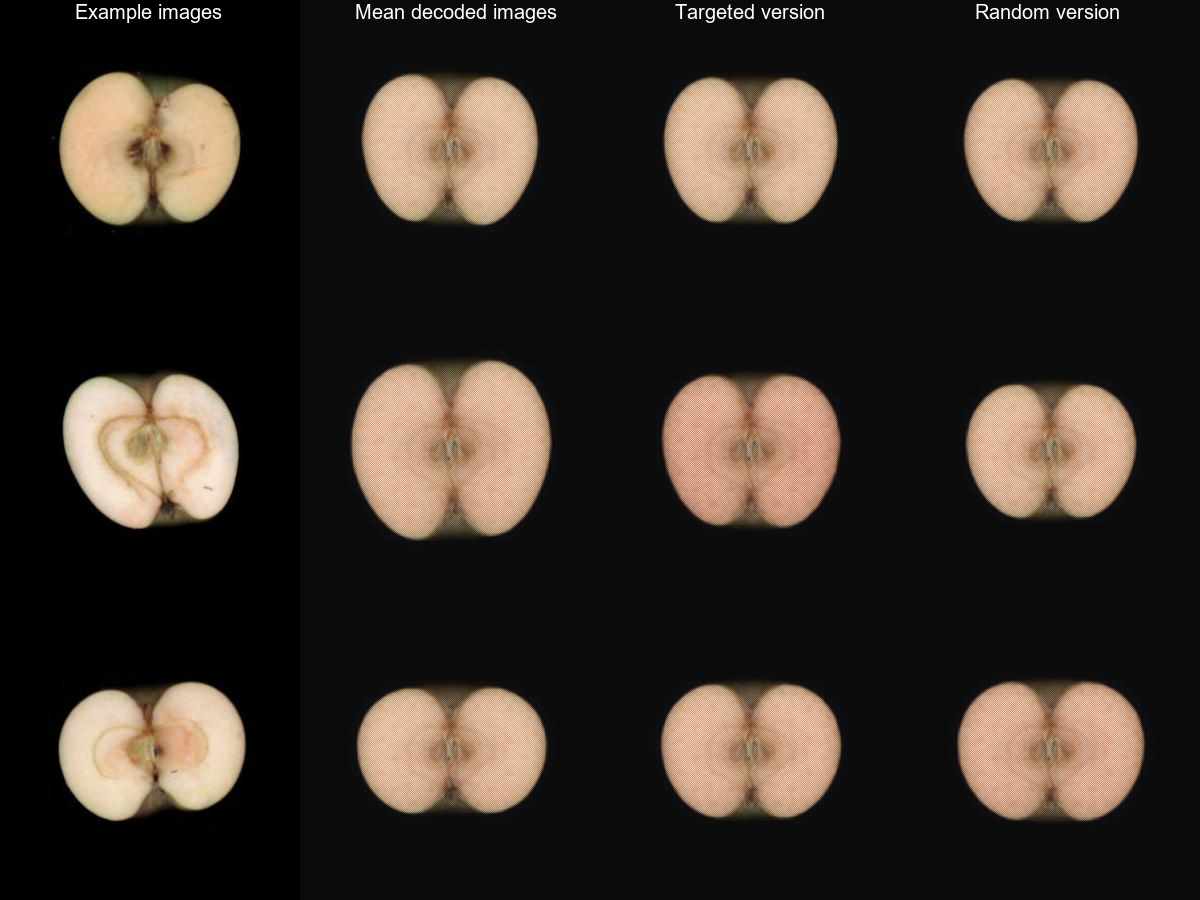

In [7]:
composition = Image.new("RGB", (images_final[0].width*4, images_final[0].height*3))
for i in range(3):
    for j in range(4):
        composition.paste(images_final[i*4+j], (images_final[i*4+j].width*j, images_final[i*4+j].height*i))
draw = ImageDraw.Draw(composition)
font = ImageFont.truetype("arial.ttf", 20)
draw.text((75, 0), "Example images", font=font)
draw.text((355, 0), "Mean decoded images", font=font)
draw.text((675, 0), "Targeted version", font=font)
draw.text((975, 0), "Random version", font=font)
composition.save("Figures/GenoDrawing_examples.png")
composition